In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import os
from scipy.cluster import hierarchy

# NBA tests

In [2]:
def get_player_data_from_df(df, column):
    '''
        df: player dataframe;
        column: column to return data from;
    '''
    player_game_ids = list(df['game_id'])
    player_game_ids_idx = 0
    
    player_data = []
    
    for game_id in range(1,83):
        if game_id not in player_game_ids:
            player_data.append(0)
        else:
            player_game_id_data = df[df.game_id == game_id][column].values[0]
            player_data.append(player_game_id_data)
        
    return np.array(player_data)

def generate_pivoted_player_data_df(df, data):
    '''
        df: player dataframe;
        data: complete data of desired column
    '''
    df_aux = pd.DataFrame()
    df_aux['name'] = [df['name'].values[0]]*82
    df_aux['game_id'] = range(1,83)
    df_aux['data'] = data
    
    pivoted_df = df_aux.pivot("name","game_id","data")
    return pivoted_df
    

In [71]:
def check_events(points, three_pts_made):
    data_after_events = []
    
    for i in range(len(points)):
        if points[i]>=24 and three_pts_made[i]>=4:
            data_after_events.append(3)
        elif points[i]>24:
            data_after_events.append(2)
        elif three_pts_made[i]>4:
            data_after_events.append(1)
        else:
            data_after_events.append(0)
            
    return data_after_events

def check_doubles(points, assists, rebounds, steals, blocks):
    stats = [points, assists, rebounds, steals, blocks]
    data_after_events = []
    
    for game in range(82):
        stats_over_10 = len([stats[stat][game] for stat in range(len(stats)) if stats[stat][game] >= 10 ])
        if stats_over_10 > 3:
            data_after_events.append(3)
        elif stats_over_10 == 3:
            data_after_events.append(2)
        elif stats_over_10 == 2:
            data_after_events.append(1)
        else:
            data_after_events.append(0)
        

In [72]:
def build_df_to_heatmap(data_path):
    '''
        path: path to folder containing data from players
    '''
    
    data_dfs = []
    for fname in os.listdir(data_path):
        df_player = pd.read_csv(data_path+'/'+fname, sep='|')

        player_data_points = get_player_data_from_df(df_player, 'points')
        player_data_assists = get_player_data_from_df(df_player, 'assists')
        player_data_rebounds = get_player_data_from_df(df_player, 'rebounds')
        player_data_steals = get_player_data_from_df(df_player, 'steals')
        player_data_blocks = get_player_data_from_df(df_player, 'blocks')
        #player_data_3ptm   = get_player_data_from_df(df_player,'made_three_point_field_goals')
        #player_data_after_events = check_events(player_data_points, player_data_3ptm)
        player_data_after_events = check_doubles(player_data_points,
                                                 player_data_assists,
                                                 player_data_rebounds,
                                                 player_data_steals,
                                                 player_data_blocks)
        
        data_dfs.append(generate_pivoted_player_data_df(df_player, player_data_after_events))

    dfs = pd.concat(data_dfs)
    return dfs

In [75]:
def set_heatmap_data(data_path):
    '''
        path: path to folder containing data from players
    '''
    data_names  = []
    data_values = []
    for fname in os.listdir(data_path):
        df_player = pd.read_csv(data_path+'/'+fname, sep='|')

        player_data_points = get_player_data_from_df(df_player, 'points')
        #player_data_assists = get_player_data_from_df(df_player, 'assists')
        #player_data_rebounds = get_player_data_from_df(df_player, 'rebounds')
        #player_data_steals = get_player_data_from_df(df_player, 'steals')
        #player_data_blocks = get_player_data_from_df(df_player, 'blocks')
        player_data_3ptm   = get_player_data_from_df(df_player,'made_three_point_field_goals')
        player_data_after_events = check_events(player_data_points, player_data_3ptm)
        #player_data_after_events = check_doubles(player_data_points, player_data_assists, player_data_rebounds, player_data_steals, player_data_blocks)
        
        data_names.append(df_player['name'].values[0])
        data_values.append(player_data_after_events)
    
    Z = hierarchy.ward(data_values)
    sorted_idxs = hierarchy.leaves_list(Z)
    sorted_names = []
    sorted_values = []

    for idx in sorted_idxs:
        sorted_names.append(data_names[idx])
        sorted_values.append(data_values[idx])
    
    return sorted_names, sorted_values

## Comparing All-NBA teams

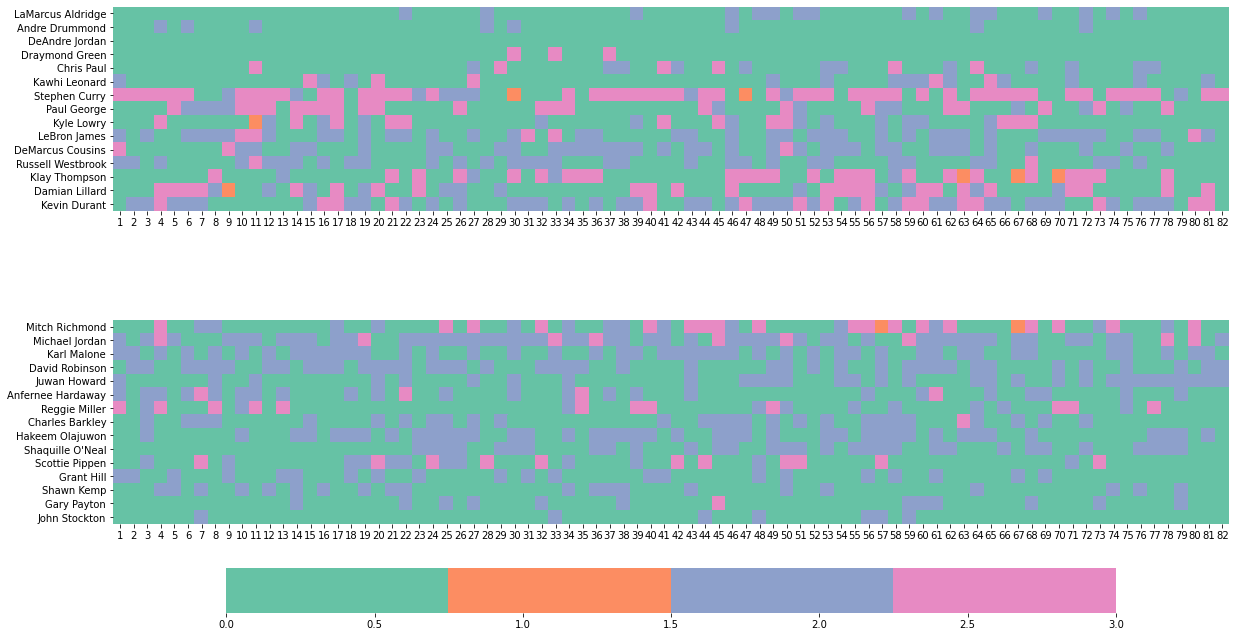

In [77]:
names_1516, values_1516 = set_heatmap_data(r'../../data/NBA/nba_1516/all_nba_1516')
names_9596, values_9596 = set_heatmap_data(r'../../data/NBA/nba_9596/all_nba_9596')

f, axs = plt.subplots(2,1,figsize=(20,12))
n=4

sb.heatmap(values_1516,ax=axs[0],cmap=sb.color_palette("Set2", n),cbar=False,square=True)
axs[0].set_yticklabels(names_1516, rotation=360)
axs[0].set_xticklabels(range(1,83))

sb.heatmap(values_9596,ax=axs[1],cmap=sb.color_palette("Set2", n),cbar=True,square=True,
           cbar_kws=dict(use_gridspec=False,location="bottom"))
axs[1].set_yticklabels(names_9596, rotation=360)
axs[1].set_xticklabels(range(1,83))

plt.show()

## Comparing '96 All-Stars with '16 All-Stars

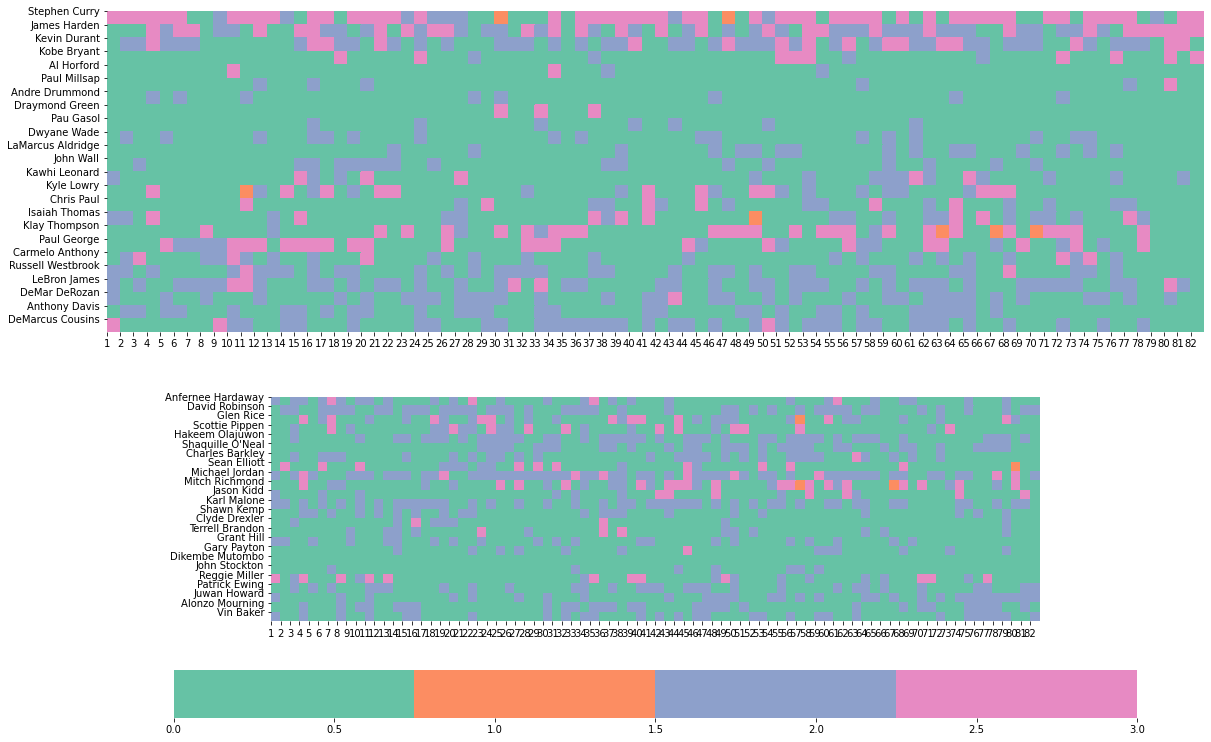

In [50]:
allstar_names_1516, allstar_values_1516 = set_heatmap_data(r'../../data/NBA/nba_1516/nba_allstar_1516')
allstar_names_9596, allstar_values_9596 = set_heatmap_data(r'../../data/NBA/nba_9596/nba_allstar_9596')

f, axs = plt.subplots(2,1,figsize=(20,13))
n=4

sb.heatmap(allstar_values_1516,ax=axs[0],cmap=sb.color_palette("Set2", n),cbar=False,square=True)
axs[0].set_yticks(range(24))
axs[0].set_xticks(range(82))
axs[0].set_yticklabels(allstar_names_1516, rotation=360)
axs[0].set_xticklabels(range(1,83), rotation=360)

sb.heatmap(allstar_values_9596,ax=axs[1],cmap=sb.color_palette("Set2", n),cbar=True,square=True,
           cbar_kws=dict(use_gridspec=False,location="bottom"))
axs[1].set_yticks(range(24))
axs[1].set_xticks(range(82))
axs[1].set_yticklabels(allstar_names_9596, rotation=360)
axs[1].set_xticklabels(range(1,83), rotation=360)

for axes in axs:
    axes.set_aspect(1)

# plt.tight_layout()

plt.show()

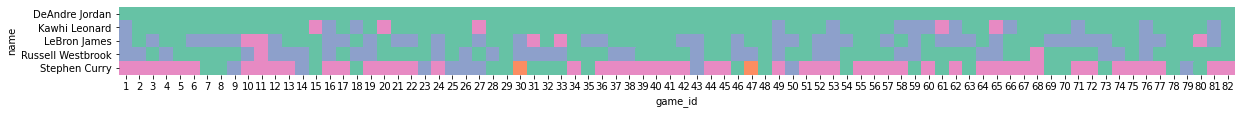

In [47]:
plt.figure(figsize=(20,30))
all_nba_fst_1516 = build_df_to_heatmap(r'../../data/NBA/all_nba_first_1516')
n=4
sb.heatmap(all_nba_fst_1516,cmap=sb.color_palette("Set2", n),cbar=False,square=True)
plt.show()

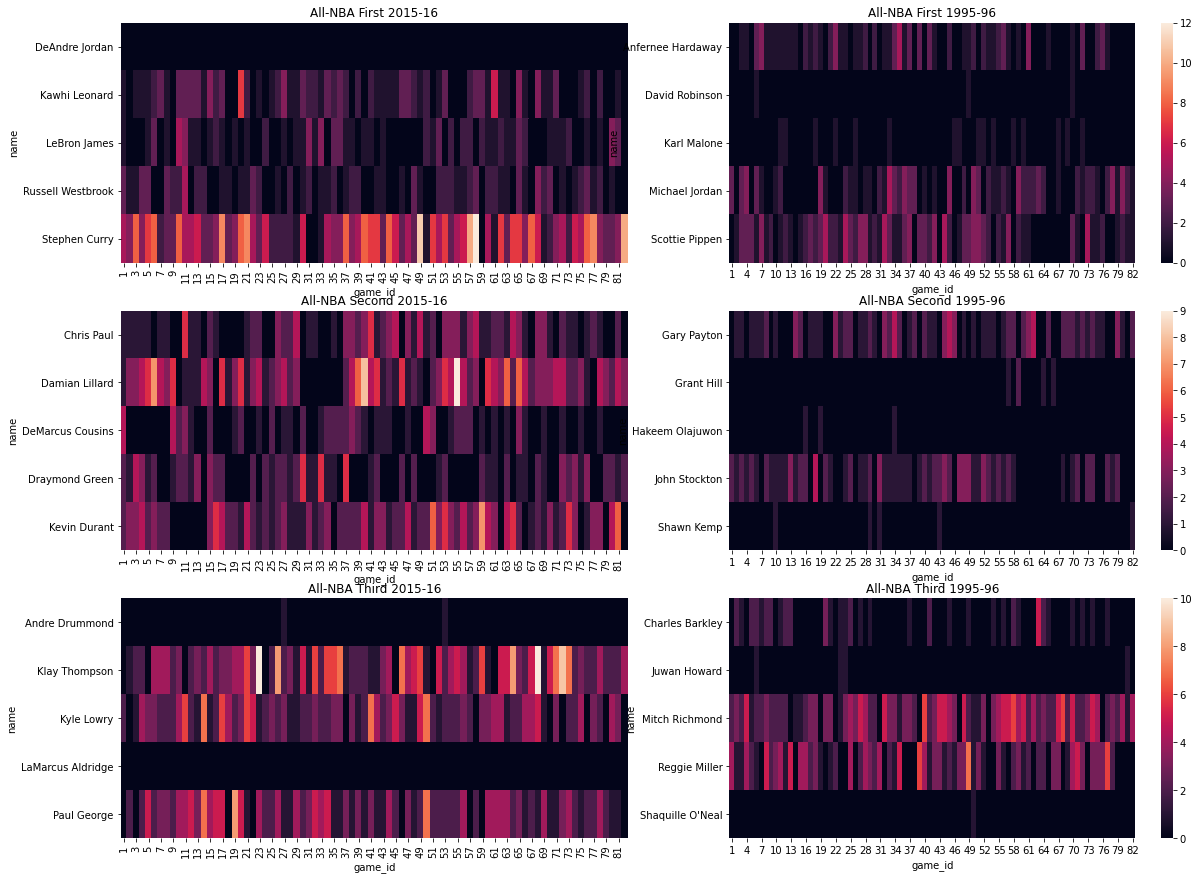

In [38]:
all_nba_fst_1516 = build_df_to_heatmap(r'../../data/NBA/all_nba_first_1516')
all_nba_snd_1516 = build_df_to_heatmap(r'../../data/NBA/all_nba_second_1516')
all_nba_trd_1516 = build_df_to_heatmap(r'../../data/NBA/all_nba_third_1516')
all_nba_fst_9596 = build_df_to_heatmap(r'../../data/NBA/all_nba_first_9596')
all_nba_snd_9596 = build_df_to_heatmap(r'../../data/NBA/all_nba_second_9596')
all_nba_trd_9596 = build_df_to_heatmap(r'../../data/NBA/all_nba_third_9596')

f, axs = plt.subplots(3,2,figsize=(20,15))

sb.heatmap(all_nba_fst_1516,ax=axs[0,0],vmin=0,vmax=12,cbar=False)
axs[0,0].title.set_text('All-NBA First 2015-16')
sb.heatmap(all_nba_fst_9596,ax=axs[0,1],vmin=0,vmax=12,cbar=True)
axs[0,1].title.set_text('All-NBA First 1995-96')
sb.heatmap(all_nba_snd_1516,ax=axs[1,0],vmin=0,vmax=9,cbar=False)
axs[1,0].title.set_text('All-NBA Second 2015-16')
sb.heatmap(all_nba_snd_9596,ax=axs[1,1],vmin=0,vmax=9,cbar=True)
axs[1,1].title.set_text('All-NBA Second 1995-96')
sb.heatmap(all_nba_trd_1516,ax=axs[2,0],vmin=0,vmax=10,cbar=False)
axs[2,0].title.set_text('All-NBA Third 2015-16')
sb.heatmap(all_nba_trd_9596,ax=axs[2,1],vmin=0,vmax=10,cbar=True)
axs[2,1].title.set_text('All-NBA Third 1995-96')

plt.show()

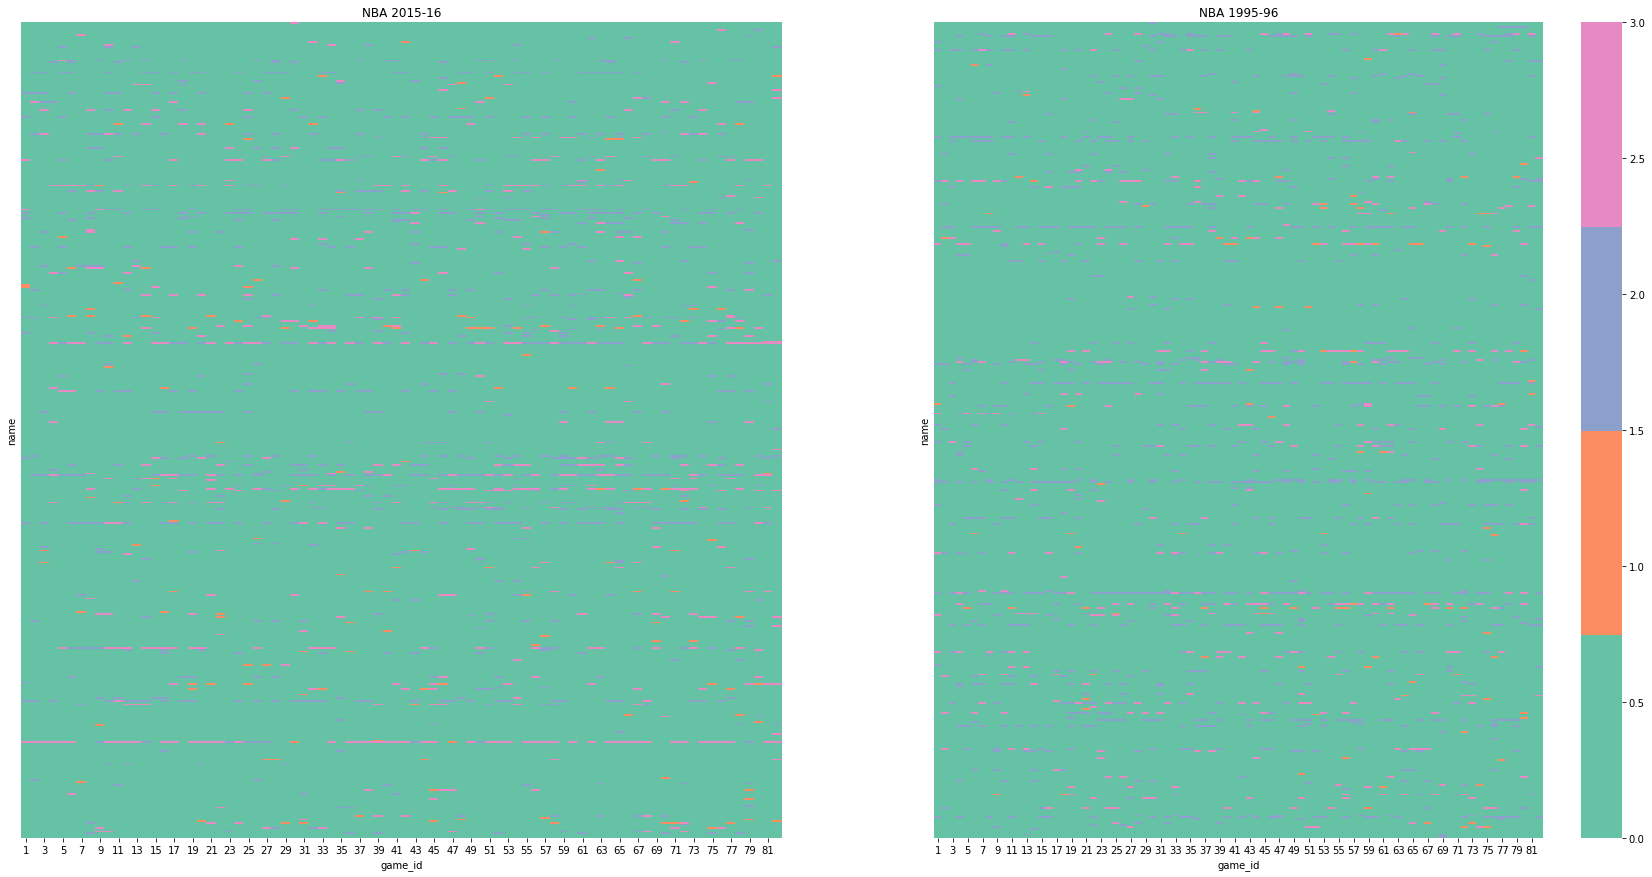

In [76]:
nba_1516 = build_df_to_heatmap(r'../../data/NBA/nba_players_1516')
nba_9596 = build_df_to_heatmap(r'../../data/NBA/nba_players_9596')

f, axs = plt.subplots(1,2,figsize=(30,15))

axs[0].title.set_text('NBA 2015-16')
sb.heatmap(nba_1516,ax=axs[0], yticklabels=[], cmap=sb.color_palette("Set2", 4), cbar=False)
axs[1].title.set_text('NBA 1995-96')
sb.heatmap(nba_9596,ax=axs[1], yticklabels=[], cmap=sb.color_palette("Set2", 4), cbar=True)

plt.show()

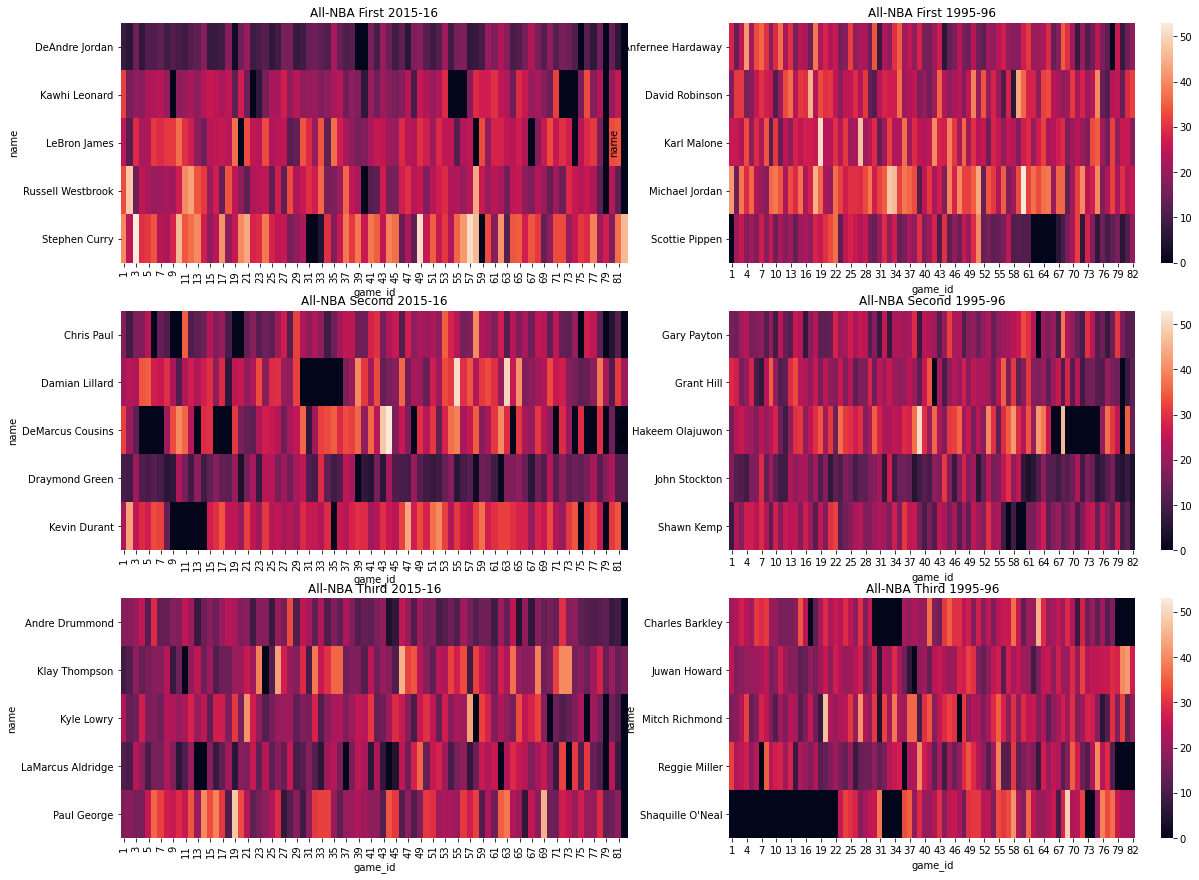

In [42]:
all_nba_fst_1516 = build_df_to_heatmap(r'../../data/NBA/all_nba_first_1516')
all_nba_snd_1516 = build_df_to_heatmap(r'../../data/NBA/all_nba_second_1516')
all_nba_trd_1516 = build_df_to_heatmap(r'../../data/NBA/all_nba_third_1516')
all_nba_fst_9596 = build_df_to_heatmap(r'../../data/NBA/all_nba_first_9596')
all_nba_snd_9596 = build_df_to_heatmap(r'../../data/NBA/all_nba_second_9596')
all_nba_trd_9596 = build_df_to_heatmap(r'../../data/NBA/all_nba_third_9596')

f, axs = plt.subplots(3,2,figsize=(20,15))

sb.heatmap(all_nba_fst_1516,ax=axs[0,0],vmin=0,vmax=53,cbar=False)
axs[0,0].title.set_text('All-NBA First 2015-16')
sb.heatmap(all_nba_fst_9596,ax=axs[0,1],vmin=0,vmax=53,cbar=True)
axs[0,1].title.set_text('All-NBA First 1995-96')
sb.heatmap(all_nba_snd_1516,ax=axs[1,0],vmin=0,vmax=53,cbar=False)
axs[1,0].title.set_text('All-NBA Second 2015-16')
sb.heatmap(all_nba_snd_9596,ax=axs[1,1],vmin=0,vmax=53,cbar=True)
axs[1,1].title.set_text('All-NBA Second 1995-96')
sb.heatmap(all_nba_trd_1516,ax=axs[2,0],vmin=0,vmax=53,cbar=False)
axs[2,0].title.set_text('All-NBA Third 2015-16')
sb.heatmap(all_nba_trd_9596,ax=axs[2,1],vmin=0,vmax=53,cbar=True)
axs[2,1].title.set_text('All-NBA Third 1995-96')

plt.show()

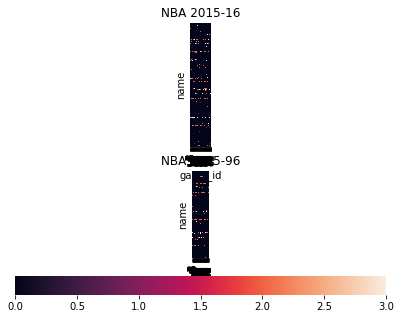

In [67]:
nba_1516 = build_df_to_heatmap(r'../../data/NBA/nba_players_1516')
nba_9596 = build_df_to_heatmap(r'../../data/NBA/nba_players_9596')

f, axs = plt.subplots(2,1,figsize=(30,5))

axs[0].title.set_text('NBA 2015-16')
sb.heatmap(nba_1516,ax=axs[0], yticklabels=[], cbar=False, square=True)
axs[1].title.set_text('NBA 1995-96')
sb.heatmap(nba_9596,ax=axs[1], yticklabels=[], cbar=True, square=True,
           cbar_kws=dict(use_gridspec=False,location="bottom"))

plt.show()

# COVID Data

In [183]:
from datetime import datetime
from datetime import date
import matplotlib.dates as mdates

In [184]:
br_path = r'../data/COVID/locations/Brazil'
br_df = pd.read_csv(br_path)

us_path = r'../data/COVID/locations/United States'
us_df = pd.read_csv(us_path)

In [185]:
def get_location_data_from_df(df, column):
    '''
        df: location dataframe;
        column: column to return data from;
    '''
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    all_dates = pd.date_range(start="2020-01-22",end="2021-07-04")
    location_dates = list(df['date'])
    location_data = []
    
    for date in all_dates:
        if date not in location_dates:
            location_data.append(0)
        else:
            location_date_data = df[df.date == date][column].values[0]
            location_data.append(location_date_data)
        
    return np.array(location_data)

In [225]:
def set_covid_heatmap_data(data_path):
    '''
        path: path to folder containing data from locations
    '''
    data_names  = []
    data_values = []
    for fname in os.listdir(data_path):
        df_location = pd.read_csv(data_path+'/'+fname)
        
        location_data_new_deaths   = get_location_data_from_df(df_location, 'new_cases')
        location_data_after_events = location_data_new_deaths
        
        data_names.append(df_location['location'].values[0])
        data_values.append(location_data_after_events)
    
    Z = hierarchy.ward(data_values)
    sorted_idxs = hierarchy.leaves_list(Z)
    sorted_names = []
    sorted_values = []

    for idx in sorted_idxs:
        sorted_names.append(data_names[idx])
        sorted_values.append(data_values[idx])
    
    return sorted_names, sorted_values

In [226]:
snames, sdata = set_covid_heatmap_data(r'../data/COVID/locations_filtered')

In [227]:
df_data = []
xs = [x.date() for x in pd.date_range(start="2020-01-22",end="2021-07-04")]
for idx in range(len(snames)):
    df_location = pd.DataFrame({'dates':xs,'location':[snames[idx]]*len(xs),'data':sdata[idx]})
    pivoted_df = df_location.pivot(index='location',columns='dates',values='data')
    df_data.append(pivoted_df)

df_data = pd.concat(df_data)
df_data

dates,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2021-06-25,2021-06-26,2021-06-27,2021-06-28,2021-06-29,2021-06-30,2021-07-01,2021-07-02,2021-07-03,2021-07-04
location,,,,,,,,,,,,,,,,,,,,,
India,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,48698.0,50040.0,46148.0,37566.0,45951.0,48786.0,46617.0,44111.0,43071.0,39796.0
United States,0.0,0.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,2.0,...,23715.0,7303.0,3920.0,15083.0,11596.0,12872.0,14463.0,29698.0,4739.0,3697.0
Brazil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,79277.0,64134.0,33704.0,27804.0,64903.0,43836.0,65163.0,65165.0,54556.0,27783.0
France,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1988.0,2128.0,1578.0,518.0,3395.0,1380.0,2664.0,2687.0,3006.0,2549.0
China,0.0,93.0,277.0,483.0,666.0,802.0,2632.0,576.0,2054.0,1659.0,...,25.0,14.0,22.0,18.0,9.0,12.0,18.0,23.0,15.0,22.0
Italy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,751.0,838.0,780.0,387.0,677.0,776.0,879.0,794.0,929.0,806.0
United Kingdom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,15374.0,17946.0,14633.0,22723.0,20261.0,25670.0,27646.0,26863.0,24465.0,23896.0


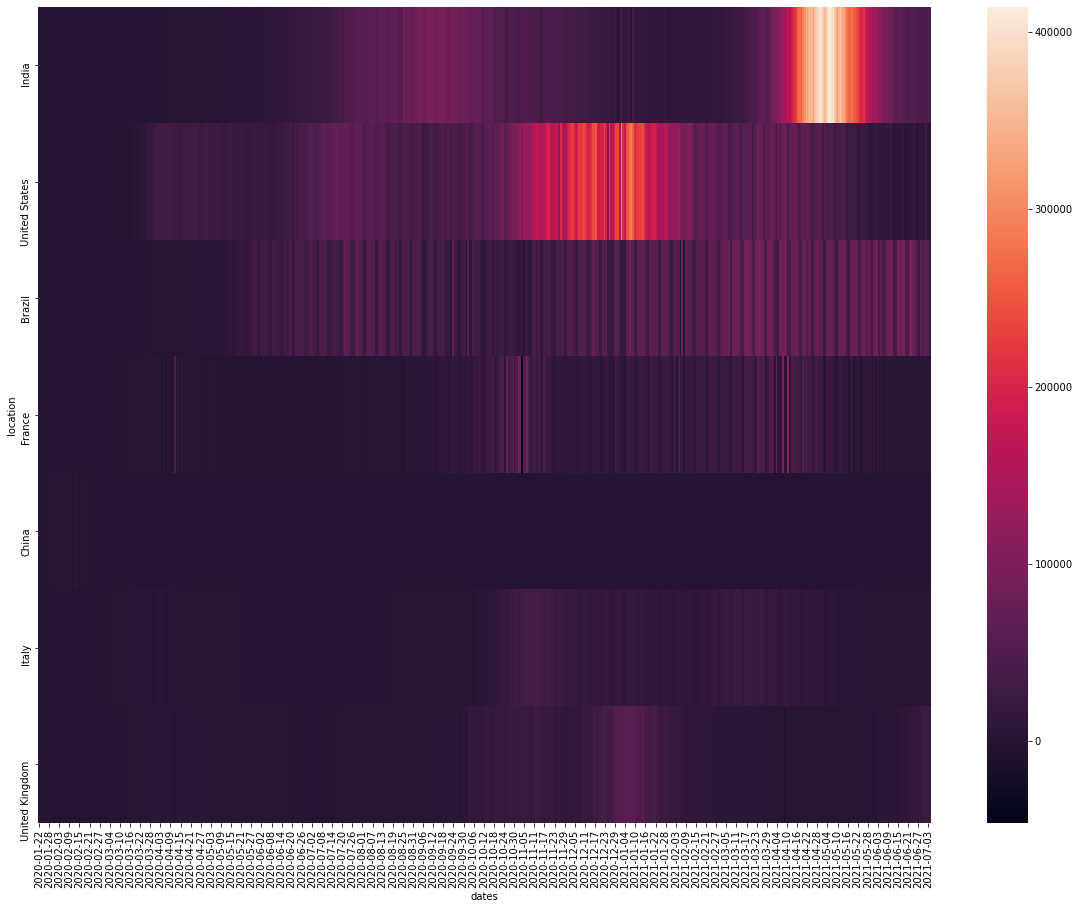

In [228]:
plt.figure(figsize=(20,15))
h = sb.heatmap(df_data)
plt.show()